In [13]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [14]:
random.seed(42)

In [15]:
# import allocations for lead day 5 and lead day 0 and calculate wmape values

allocation_dir = 'allocations'
merged_dir = 'merged'
lead_day = 5
soft_col = f'lead_{lead_day}'
hard_col = 'lead_0'

allocation_0 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_0.csv')
allocation_5 = pd.read_csv(f'{allocation_dir}/allocation_lead_day_5.csv')

merged_5_0 = pd.read_csv(f'{merged_dir}/merged_lead_day_{lead_day}_0.csv')

_, wmape_site = WMAPE.calculate_wmape_site(merged_5_0, soft_col, hard_col)
_, wmape_global = WMAPE.calculate_wmape_global(merged_5_0, soft_col, hard_col)

print(f'wmape_global: {wmape_global}')
print(f'wmape_site: {wmape_site}')

wmape_global: 0.23284907183212267
wmape_site: 0.4854721549636804


In [93]:
# Objective Function
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_target_df, aggregated_initial_df, target_day, initial_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')

    return wmape_site

In [82]:
# Generate Neighbor Function
def generate_neighbor(current_allocation, orders_df, eligibility_dict):
    new_allocation = current_allocation.copy()
    max_attempts = 100  # Limit the number of attempts to find a valid swap

    unique_order_ids = orders_df['order_id'].unique()

    for _ in range(max_attempts):
        order_indices = random.sample(range(len(unique_order_ids)), 2)

        order_id1 = unique_order_ids[order_indices[0]]
        order_id2 = unique_order_ids[order_indices[1]]

        items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
        items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()

        site1 = new_allocation[orders_df[orders_df['order_id'] == order_id1].index[0]]
        site2 = new_allocation[orders_df[orders_df['order_id'] == order_id2].index[0]]

        if all(item in eligibility_dict[site2] for item in items1) and all(item in eligibility_dict[site1] for item in items2):
            # Perform the swap if both are eligible
            new_allocation[orders_df[orders_df['order_id'] == order_id1].index] = site2
            new_allocation[orders_df[orders_df['order_id'] == order_id2].index] = site1
            break

    return new_allocation

In [83]:
def acceptance_probability(current_energy, new_energy, temperature):
    if new_energy < current_energy:
        return 1.0
    else:
        return math.exp((current_energy - new_energy) / temperature)

def cooling_schedule(temp, alpha, improvement_rate):
    if improvement_rate > 0.01:
        alpha = min(alpha * 1.01, 0.99)  # Slightly increase alpha but cap it to 0.99
    elif improvement_rate < 0.001:
        alpha = max(alpha * 0.99, 0.90)  # Slightly decrease alpha but ensure it doesn't drop too low
    return temp * alpha

In [84]:
# Aggregate, Merge DataFrames and Calculate WMAPE
def calculate_wmape_for_all_days(lead_days):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'hybrid_sa_2opt_allocations/sa_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'hybrid_sa_2opt_allocations/sa_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'hybrid_sa_2opt_merged/sa_2opt_merged_allocation_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values

# Plot the WMAPE Values
def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()

In [85]:
def valid_allocation(order_id, target_site, orders, eligibility_dict):
    order_items = orders[orders['order_id'] == order_id]['item_id'].tolist()
    return all(item in eligibility_dict[target_site] for item in order_items)

def hybrid_sa_2opt(orders, target_orders, eligibility_dict, initial_day, target_day, initial_temp, final_temp, alpha, max_iter, fixed_steps=10):
    current_allocation = orders['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders, target_orders, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    while temp > final_temp and step < max_iter:
        new_allocation = generate_neighbor(current_allocation, orders, eligibility_dict)
        new_energy = objective_function(new_allocation, orders, target_orders, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        best_local_allocation, best_local_energy = two_opt(orders, target_orders, eligibility_dict, initial_day, target_day, fixed_steps)

        if best_energy > best_local_energy:
            best_energy = best_local_energy
            best_allocation = best_local_allocation
        
        improvement_rate = (current_energy - best_energy) / current_energy
        temp = cooling_schedule(temp, alpha, improvement_rate)
        step += 1
        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')
    return best_allocation, best_energy



def two_opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, fixed_steps):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    step = 0
    while step < fixed_steps:
        # Select random order A
        a_index = random.choice(range(len(current_allocation)))
        a_order_id = orders_df.iloc[a_index]['order_id']

        # Attempt to swap with random orders until a valid swap is found
        valid_swap = False
        while not valid_swap and step < fixed_steps:
            b_index = random.choice(range(len(current_allocation)))
            if b_index != a_index:
                b_order_id = orders_df.iloc[b_index]['order_id']
                
                # Perform the swap
                new_allocation = current_allocation.copy()
                new_allocation[a_index], new_allocation[b_index] = new_allocation[b_index], new_allocation[a_index]

                # Check eligibility criteria
                a_items = orders_df[orders_df['order_id'] == a_order_id]['item_id'].values
                b_items = orders_df[orders_df['order_id'] == b_order_id]['item_id'].values
                a_site = new_allocation[a_index]
                b_site = new_allocation[b_index]

                if all(item in eligibility_dict[a_site] for item in a_items) and all(item in eligibility_dict[b_site] for item in b_items):
                    valid_swap = True
                    new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)
                    if new_energy < best_energy:
                        best_allocation = new_allocation
                        best_energy = new_energy
                        current_allocation = best_allocation
                        current_energy = best_energy
                    else:
                        current_allocation = new_allocation

            step += 1
    return best_allocation, best_energy

def perform_hybrid_sa_2opt(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):
    allocation_dir = 'allocations'
    sa_allocation_dir = 'hybrid_sa_2opt_allocations'
    
    if not os.path.exists(sa_allocation_dir):
        os.makedirs(sa_allocation_dir)

    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)

    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i - 1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
        target_orders = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{previous_day}.csv')

        best_allocation, best_energy = hybrid_sa_2opt(current_df.copy(), target_orders.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha, max_iter, fixed_steps=10)
        current_df['site'] = best_allocation

        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)



In [24]:
lead_days = list(range(18, -1, -1)) 
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')
initial_temp = 5000
final_temp = 0.1
alpha = 0.99
max_iter = 5000

# 50 minutes 42 seconds
perform_hybrid_sa_2opt(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict)


Step 100: Best Energy 0.34924932316022644, Temperature: 1740.4655724622112
Step 200: Best Energy 0.34924932316022644, Temperature: 637.066688393794
Step 300: Best Energy 0.3480187053901058, Temperature: 219.5409424253581
Step 400: Best Energy 0.3480187053901058, Temperature: 80.35908516128507
Step 500: Best Energy 0.3480187053901058, Temperature: 29.414024084159987
Step 600: Best Energy 0.3480187053901058, Temperature: 10.76648410179223
Step 700: Best Energy 0.3480187053901058, Temperature: 3.9408813830600113
Step 800: Best Energy 0.3480187053901058, Temperature: 1.4424900393215383
Step 900: Best Energy 0.3480187053901058, Temperature: 0.5279980063561751
Step 1000: Best Energy 0.3480187053901058, Temperature: 0.19326434645414814
Step 100: Best Energy 0.41827719491993376, Temperature: 1395.2104429252938
Step 200: Best Energy 0.4180011043622308, Temperature: 461.8608217792893
Step 300: Best Energy 0.41496410822749863, Temperature: 165.69178357927981
Step 400: Best Energy 0.41385974599668

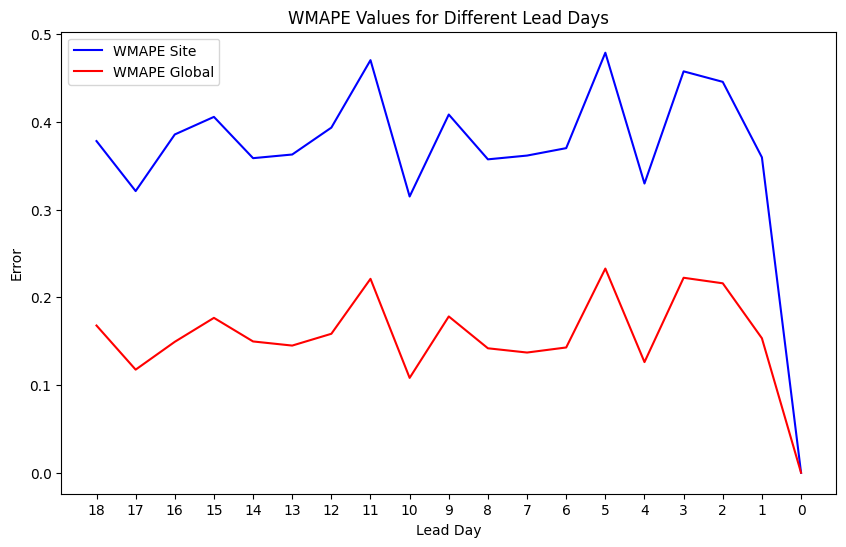

In [15]:
lead_days = list(range(18, -1, -1)) 
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)

# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

In [99]:
def calculate_and_plot_wmape(pairs):
    wmape_site_values = []
    wmape_global_values = []
    wmape_site_sa_values = []
    wmape_global_sa_values = []

    hybrid_allocation_dir = 'hybrid_sa_2opt_allocations'  # Path to the directory containing the simulated annealing allocation files
    hybrid_merged_allocation_dir = 'hybrid_sa_2opt_merged_consec'  # Path to the directory to save the merged allocation files

    for previous_day, current_day in pairs:

        merged_df = pd.read_csv(f'merged_consec/merged_allocation_lead_day_{previous_day}_to_{current_day}.csv')
        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{previous_day}', f'lead_{current_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{previous_day}', f'lead_{current_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

        # With simulated annealing
        current_df_sa = pd.read_csv(f'{hybrid_allocation_dir}/sa_allocation_lead_day_{current_day}.csv')
        previous_df_sa = pd.read_csv(f'{hybrid_allocation_dir}/sa_allocation_lead_day_{previous_day}.csv')

        aggregated_current_day_sa = OrderMerger.aggregate_items(current_df_sa, current_day)
        aggregated_previous_day_sa = OrderMerger.aggregate_items(previous_df_sa, previous_day)

        merged_df_sa_2opt = OrderMerger.merge_allocation(aggregated_previous_day_sa, aggregated_current_day_sa, previous_day, current_day)

        _, wmape_site_sa = WMAPE.calculate_wmape_site(merged_df_sa_2opt, f'lead_{previous_day}', f'lead_{current_day}')
        _, wmape_global_sa = WMAPE.calculate_wmape_global(merged_df_sa_2opt, f'lead_{previous_day}', f'lead_{current_day}')

        wmape_site_sa_values.append(wmape_site_sa)
        wmape_global_sa_values.append(wmape_global_sa)

        # Save the merged dataframes with simulated annealing
        merged_df_sa_2opt.to_csv(f'{hybrid_merged_allocation_dir}/merged_allocation_sa_2opt_lead_day_{previous_day}_to_{current_day}.csv', index=False)

    lead_days_consecutive = [previous_day for _, previous_day in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days_consecutive, wmape_site_values, linestyle='-', color='b', label='WMAPE Site Without hybrid SA-2opt')
    ax.plot(lead_days_consecutive, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')
    ax.plot(lead_days_consecutive, wmape_site_sa_values, linestyle='--', color='b', label='WMAPE Site With hybrid SA-Sopt')

    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Consecutive Lead Days')
    ax.set_xticks(lead_days_consecutive)
    ax.legend()

    ax.invert_xaxis()

    plt.show()

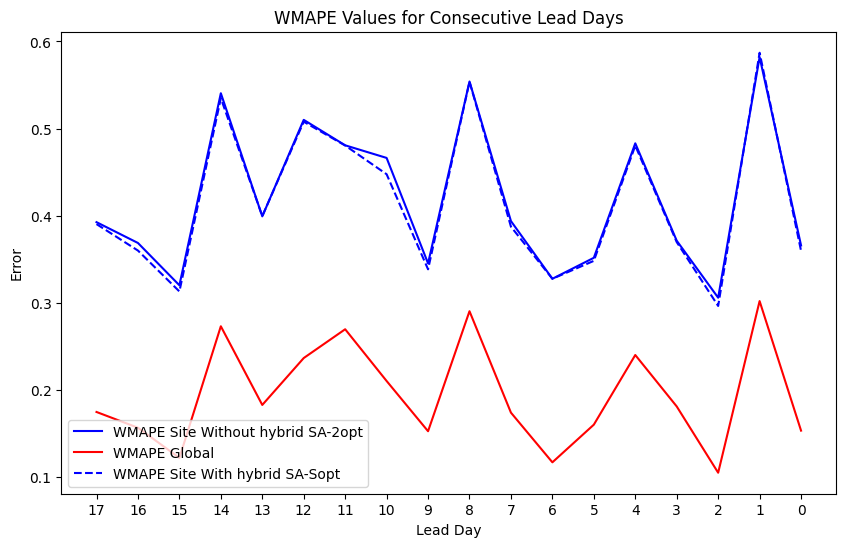

In [102]:
pairs = [(18, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]
calculate_and_plot_wmape(pairs)

In [101]:
def calculate_area_under_curve(lead_days, merged_consec_dir):
    wmape_values = []
    
    # Reverse the lead_days array to ensure ascending order
    lead_days = sorted(lead_days)

    # Calculate WMAPE for each consecutive lead day pair
    for i in range(1, len(lead_days)):
        soft_day = lead_days[i]
        hard_day = lead_days[i - 1]
        
        merged_df = pd.read_csv(f"{merged_consec_dir}/merged_allocation_sa_2opt_lead_day_{soft_day}_to_{hard_day}.csv")
        _, wmape_site_value = WMAPE.calculate_wmape_site(merged_df, soft_col=f'lead_{soft_day}', hard_col=f'lead_{hard_day}')
        wmape_values.append(wmape_site_value)
    
    # Calculate area under the curve using the trapezoidal rule
    x = np.array(lead_days[1:])  # Lead days after the first one
    y = np.array(wmape_values)
    auc = np.trapz(y, x)
    
    return auc

lead_days = list(range(18, -1, -1))
merged_consec_dir = 'hybrid_sa_2opt_merged_consec'  # Directory containing merged consecutive files

auc_value = calculate_area_under_curve(lead_days, merged_consec_dir)
print(f"Area under the WMAPE site curve after hybrid simulated annealing and 2opt: {auc_value}")

Area under the WMAPE site curve after hybrid simulated annealing and 2opt: 7.107782068499294


Step 100: Best Energy 0.48062953995157387, Temperature: 1793.7414884094605
Step 200: Best Energy 0.48062953995157387, Temperature: 656.5673966414415
Step 300: Best Energy 0.48062953995157387, Temperature: 240.3249013963359
Step 400: Best Energy 0.48062953995157387, Temperature: 87.96668632435875
Step 500: Best Energy 0.48062953995157387, Temperature: 32.1986521493528
Step 600: Best Energy 0.48062953995157387, Temperature: 11.7857480320699
Step 700: Best Energy 0.48062953995157387, Temperature: 4.3139649458349
Step 800: Best Energy 0.48062953995157387, Temperature: 1.5790506892945884
Step 900: Best Energy 0.48062953995157387, Temperature: 0.5779836207916046
Step 1000: Best Energy 0.48062953995157387, Temperature: 0.21156069793592933
0.48062953995157387
0.4854721549636804


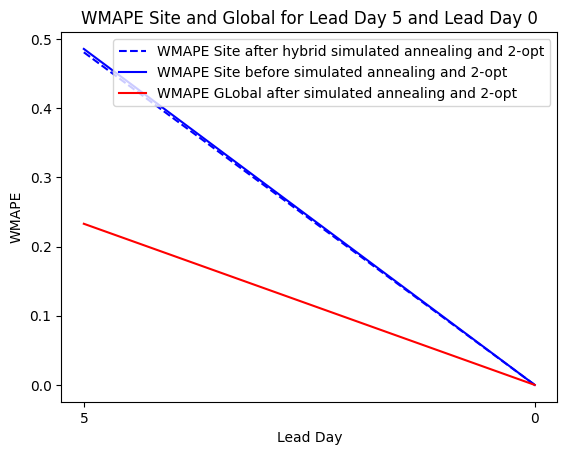

In [96]:
def perform_hybrid_sa_k_opt_and_plot(orders_df, target_orders_df, initial_day, target_day, eligibility_dict, k):
    # order before applying simulated annealing
    orders_df_prev = orders_df.copy()

    # Apply hybrid simulated annealing and 2opt between lead day 5 and lead day 0
    best_allocation, best_energy = hybrid_sa_2opt(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, initial_temp=5000, final_temp=0.1, alpha=0.99, max_iter=1000, fixed_steps=100)
    # Update orders_df with the best allocation found
    orders_df['site'] = best_allocation

    # Aggregate and merge the results with the target lead day 0
    aggregated_current_day_prev = OrderMerger.aggregate_items(orders_df_prev, 0)
    aggregated_current_day_sa_2opt = OrderMerger.aggregate_items(orders_df, 0)
    aggregated_previous_day_sa_2opt = OrderMerger.aggregate_items(target_orders_df, 5)
    merged_prev = OrderMerger.merge_allocation(aggregated_previous_day_sa_2opt, aggregated_current_day_prev, 5, 0)
    merged_df = OrderMerger.merge_allocation(aggregated_previous_day_sa_2opt, aggregated_current_day_sa_2opt, 5, 0)

    # Calculate WMAPE for results before simulated annealing
    _, wmape_site_value_prev = WMAPE.calculate_wmape_site(merged_prev, 'lead_5', 'lead_0')
    print(wmape_site_value_prev)

    # Calculate WMAPE for the simulated annealing results
    _, wmape_site_value = WMAPE.calculate_wmape_site(merged_df, 'lead_5', 'lead_0')
    _, wmape_global_value = WMAPE.calculate_wmape_global(merged_df, 'lead_5', 'lead_0')

    # Plot the results
    lead_days = [5, 0]
    wmape_site_values_prev = [wmape_site_value_prev, 0]
    wmape_site_values = [wmape_site_value, 0] 
    wmape_global_values = [wmape_global_value, 0]

    plt.plot(lead_days, wmape_site_values, linestyle='--', color='b', label=f"WMAPE Site after hybrid simulated annealing and {k}-opt")
    plt.plot(lead_days, wmape_site_values_prev, linestyle = '-', color='b', label=f"WMAPE Site before simulated annealing and {k}-opt")
    plt.plot(lead_days, wmape_global_values, linestyle='-', color='r', label=f"WMAPE GLobal after simulated annealing and {k}-opt")
    plt.xlabel('Lead Day')
    plt.ylabel('WMAPE')
    plt.title('WMAPE Site and Global for Lead Day 5 and Lead Day 0')
    plt.xticks([5, 0])
    plt.gca().invert_xaxis()  # Invert x-axis to have 0 at the end
    plt.legend()
    plt.show()

# Example usage
max_iter = 5000
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Load the orders and target orders DataFrames
orders_df = pd.read_csv('allocations/allocation_lead_day_0.csv')
target_orders_df = pd.read_csv('allocations/allocation_lead_day_5.csv')

perform_hybrid_sa_k_opt_and_plot(orders_df, target_orders_df, 0, 5, eligibility_dict, k=2)